## Self supervised large scale generalisatiom

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

In [17]:
s3_prefix = "s3://aegovan-data/selfsupervised_chemprot/predictions_selfsupervised-bert-f1-2022-09-17-23-42-42-470/2022091920/"
s3_output_prefix = "{}_negative_generalisation/".format(s3_prefix.rstrip("/"))
s3_training = "s3://aegovan-data/self-supervised/train.json"

s3_prefix = "s3://aegovan-data/selfsupervised_chemprot/predictions_selfsupervised-fake-3048-767-573-bert-f-2022-10-16-05-09-43-840/2022101613/"
s3_output_prefix = "{}_negative_generalisation/".format(s3_prefix.rstrip("/"))
s3_training = "s3://aegovan-data/self-supervised-fake/base/train.json"



In [3]:
is_download_files= True

In [4]:
label_order = ["False", "True"]
pos_labels = list( filter(lambda x: x , label_order))
label_order_key = lambda x:  label_order.index(x)

label_title_map = {}

In [5]:
local_temp = "../temp"
local_temp_pred_dir = os.path.join( local_temp, "pred_results")
local_temp_wk_dir = os.path.join( local_temp, "wk")

In [6]:
import shutil

def setup_dir(local_temp,local_temp_pred_dir, local_temp_wk_dir):
    if os.path.exists(local_temp):
        shutil.rmtree(local_temp)
    os.makedirs(local_temp_pred_dir)
    os.makedirs(local_temp_wk_dir)


In [7]:
import boto3
import glob
from multiprocessing.dummy import Pool as ThreadPool
import argparse
import datetime 
import os


def upload_file(localpath, s3path):
        """
Uploads a file to s3
        :param localpath: The local path
        :param s3path: The s3 path in format s3://mybucket/mydir/mysample.txt
        """

        bucket, key = get_bucketname_key(s3path)

        if key.endswith("/"):
            key = "{}{}".format(key, os.path.basename(localpath))
        
        s3 = boto3.client('s3')
        
        s3.upload_file(localpath, bucket, key)

def get_bucketname_key(uripath):
    assert uripath.startswith("s3://")

    path_without_scheme = uripath[5:]
    bucket_end_index = path_without_scheme.find("/")

    bucket_name = path_without_scheme
    key = "/"
    if bucket_end_index > -1:
        bucket_name = path_without_scheme[0:bucket_end_index]
        key = path_without_scheme[bucket_end_index + 1:]

    return bucket_name, key


def download_file(s3path, local_dir):
    bucket, key = get_bucketname_key(s3path)
    
    s3 = boto3.client('s3')
    
    local_file = os.path.join(local_dir, s3path.split("/")[-1])
    

    s3.download_file(bucket, key, local_file)
    
def download_object(s3path):
    bucket, key = get_bucketname_key(s3path)
    
    s3 = boto3.client('s3')    

    s3_response_object = s3.get_object(Bucket=bucket, Key=key)
    object_content = s3_response_object['Body'].read()
    
    return len(object_content)



def list_files(s3path_prefix):
    assert s3path_prefix.startswith("s3://")
    assert s3path_prefix.endswith("/")
    
    bucket, key = get_bucketname_key(s3path_prefix)
    
   
   
    s3 = boto3.resource('s3')
    
    bucket = s3.Bucket(name=bucket)

    return ( (o.bucket_name, o.key) for o in bucket.objects.filter(Prefix=key))





def upload_files(local_dir, s3_prefix, num_threads=20):    
    input_tuples = ( (f,  s3_prefix) for f in glob.glob("{}/*".format(local_dir)))
    
    with ThreadPool(num_threads) as pool:
        pool.starmap(uploadfile, input_tuples)
    


def download_files(s3_prefix, local_dir, num_threads=20):    
    input_tuples = ( ("s3://{}/{}".format(s3_bucket,s3_key),  local_dir) for s3_bucket, s3_key in list_files(s3_prefix))
    
    with ThreadPool(num_threads) as pool:
        results = pool.starmap(download_file, input_tuples)
        
        

def download_objects(s3_prefix, num_threads=20):    
    s3_files = ( "s3://{}/{}".format(s3_bucket,s3_key) for s3_bucket, s3_key in list_files(s3_prefix))
    
    with ThreadPool(num_threads) as pool:
        results = pool.map(download_object, s3_files)
        
    return sum(results)/1024
        

def get_directory_size(start_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # skip if it is symbolic link
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)
    return total_size

def get_s3file_size(bucket, key):
    s3 = boto3.client('s3')
    response = s3.head_object(Bucket=bucket, Key=key)
    size = response['ContentLength']
    return size
    
def download_files_min_files(s3_prefix, local_dir, min_file_size=310, num_threads=20):    
    input_tuples = ( ("s3://{}/{}".format(s3_bucket,s3_key),  local_dir) for s3_bucket, s3_key in list_files(s3_prefix) if get_s3file_size(s3_bucket, s3_key) > min_file_size )
    
    with ThreadPool(num_threads) as pool:
        results = pool.starmap(download_file, input_tuples)
        


In [8]:
%%time

if is_download_files:
    setup_dir(local_temp,local_temp_pred_dir, local_temp_wk_dir)
    download_files(s3_prefix, local_temp_pred_dir)

CPU times: user 36.4 s, sys: 24.1 s, total: 1min
Wall time: 3min 15s


In [9]:
!ls -l $local_temp_pred_dir | wc -l

     100


In [10]:
default_threshold =  0.99
threshold_config =  {l: { "confidence":default_threshold}  for l in label_order}


In [11]:
threshold_config

{'False': {'confidence': 0.99}, 'True': {'confidence': 0.99}}

In [12]:
def load_df_from_files(local_temp_pred_dir):
   
    list_df = []
    for f in os.listdir(local_temp_pred_dir):
        df = pd.read_json(os.path.join(local_temp_pred_dir, f), orient="records" )
        df["prediction"]=df["prediction"].astype(str)
        list_df.append(df)
    return pd.concat(list_df)


In [13]:
def get_summary_df(local_temp_pred_dir, use_std=False):
    list_df_high_quality = []
    list_df_low_quality = []
    list_df_summary = []
    for f in os.listdir(local_temp_pred_dir):
        df = pd.read_json(os.path.join(local_temp_pred_dir, f), orient="records" )
        df["prediction"]=df["prediction"].astype(str)

        
        list_df_summary.append(df[["prediction", "confidence", "confidence_std", "abstract_id"]])

        # Filter below threshold items
        high_quality_frames_per_interaction = []
        low_quality_frames_per_interaction = []


        for k,t in threshold_config.items():
            conf_median = t["confidence"]
            conf_std_median = 1.0
            
            # HQ filter query
            high_qry = "prediction == '{}' and confidence >= {} and confidence_std <= {}" .format(k, conf_median, conf_std_median)
            if not use_std:
                high_qry = "prediction == '{}' and confidence >= {} " .format(k, conf_median)
            df_sub = df.query(high_qry)
            sample = min(1000, len(df_sub) )
            high_quality_frames_per_interaction.append(df_sub.sample(n=sample))


            # Low quality filter query
            conf_min = 0.8
            conf_std_min = 0.0
            low_qry = "prediction == '{}' and confidence < {} and confidence_std > {}" .format(k, conf_min, conf_std_min)
            if not use_std:
                low_qry = "prediction == '{}' and confidence < {} " .format(k, conf_min)
            df_low = df.query(low_qry)
            sample=min(1000, len(df_low) )
            low_quality_frames_per_interaction.append(df_low.sort_values(by=["prediction", "confidence_std"]).head(n=sample))
           

        high_quality_df = pd.concat(high_quality_frames_per_interaction)
        low_quality_df = pd.concat(low_quality_frames_per_interaction)


        list_df_high_quality.append(high_quality_df)
        list_df_low_quality.append(low_quality_df)


    
    return pd.concat(list_df_high_quality), pd.concat(list_df_summary), pd.concat(list_df_low_quality)



In [14]:


def is_in_training_pubmed(df, training_df):
    return df["abstract_id"].isin(training_df["abstract_id"])

In [18]:
download_file(s3_training, local_temp_wk_dir)
training_data_file = os.path.join(local_temp_wk_dir, s3_training.split("/")[-1])
data_training_full_df = pd.read_json(training_data_file)

In [19]:
%%time 


df_high_quality_threshold, df_summary, df_low_quality_threshold = get_summary_df (local_temp_pred_dir)
df_high_quality_threshold[ "RecordInTrainingData"] = is_in_training_pubmed( df_high_quality_threshold, data_training_full_df)
df_summary["RecordInTrainingData"] = is_in_training_pubmed( df_summary, data_training_full_df)
df_low_quality_threshold[ "RecordInTrainingData"]= is_in_training_pubmed( df_low_quality_threshold, data_training_full_df)

CPU times: user 29.8 s, sys: 1.06 s, total: 30.8 s
Wall time: 31.6 s


In [20]:
df_summary.dtypes

prediction               object
confidence              float64
confidence_std          float64
abstract_id               int64
RecordInTrainingData       bool
dtype: object

In [21]:
df_summary.groupby("prediction")["confidence"].describe()

,count,mean,std,min,25%,50%,75%,max
prediction,,,,,,,,
False,2164205.0,0.989687,0.046102,0.500004,0.997927,0.998686,0.999047,0.999645
True,77505.0,0.833865,0.150617,0.500021,0.718105,0.883428,0.967492,0.999001


In [22]:
import matplotlib.gridspec as gridspec

import numpy as np

def box_plot_prediction_confidence(df, df_high_quality, subplot_spec, title_prefix="", set_title=True):
    
    df = df[~df.RecordInTrainingData].copy()
    df_high_quality = df_high_quality[~df_high_quality.RecordInTrainingData].copy()
    
    
    interaction_types = label_order
    
    num_plots = len(interaction_types)
    gs = gridspec.GridSpecFromSubplotSpec(1, len(label_order), subplot_spec=subplot_spec)
    
    for i, interaction in enumerate(interaction_types):
        df_interaction = df.query(f"prediction == '{interaction}'")
        df_interaction_high_quality = df_high_quality.query(f"prediction == '{interaction}'")
        
        if len(df_interaction) == 0: continue
        
        ax = fig.add_subplot(gs[0, i])
    
    
        # Rename columns
        new_column_names = {"confidence":"c", 
                           "confidence_std" : "v"
                            }
        df_interaction = df_interaction.rename(columns = new_column_names)
        df_interaction_high_quality=df_interaction_high_quality.rename(columns = new_column_names)
        
        
        # Style and formatting..
        
        if set_title:
            ax.set_title("{}{}\nT={} (HQ={}%)".format( title_prefix,
                                               label_title_map.get(interaction, interaction).title(),
                                               len(df_interaction),
                                               round(100 * len(df_interaction_high_quality)/len(df_interaction),2)                
                                              )
                        )
        ax.set_ylim(0,1)
        
        ax.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)
        
        ax.spines['bottom'].set_color('grey')
        ax.spines['top'].set_color('grey') 
        ax.spines['right'].set_color('grey')
        ax.spines['left'].set_color('grey')
        
        
        # Plot violin plot        
        ax.violinplot(df_interaction[["c", "v" ]],  showmeans=True )
        if len(df_interaction_high_quality) > 0:
            ax.violinplot(df_interaction_high_quality[["c", "v" ]],  showmeans=True )
        
        
        x_labels = ['C', 'V']
        
        ax.xaxis.set_tick_params(direction='out')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xticks(np.arange(1, len(x_labels) + 1))
        ax.set_xticklabels(x_labels)
        ax.set_xlim(0.25, len(x_labels) + 0.75)
        
        
       



        


In [23]:
df_high_quality_threshold.shape, df_summary.shape

((105959, 9), (2241710, 5))

/Users/aparnaelangovan/PycharmProjects/venv/large-scale-ptm-ppi/lib/python3.7/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


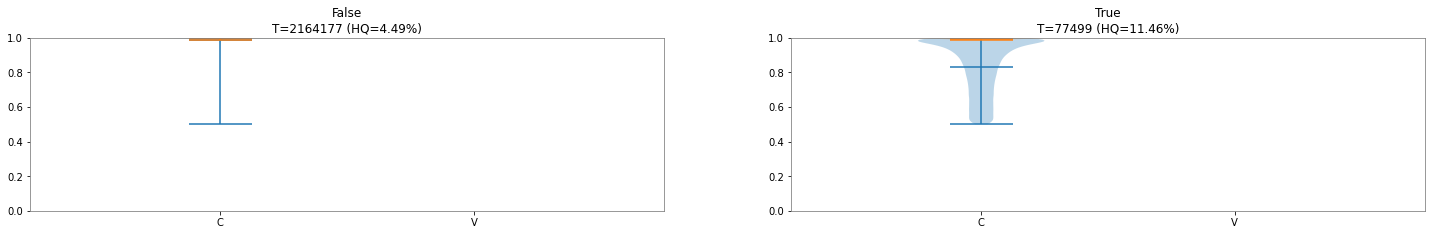

In [24]:
fig = plt.figure(figsize=(25 , 7))
gs = fig.add_gridspec(nrows=2)

box_plot_prediction_confidence(df_summary, df_high_quality_threshold, gs[0])

plt.savefig("largescaleprediction_distribution.pdf", bbox_inches="tight")

In [25]:
df_summary["confidence"].describe()

count    2.241710e+06
mean     9.842993e-01
std      6.038784e-02
min      5.000041e-01
25%      9.977493e-01
50%      9.986538e-01
75%      9.990362e-01
max      9.996448e-01
Name: confidence, dtype: float64

In [26]:
df_low_quality_threshold["prediction"].value_counts()

False    34386
True     27771
Name: prediction, dtype: int64

/Users/aparnaelangovan/PycharmProjects/venv/large-scale-ptm-ppi/lib/python3.7/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


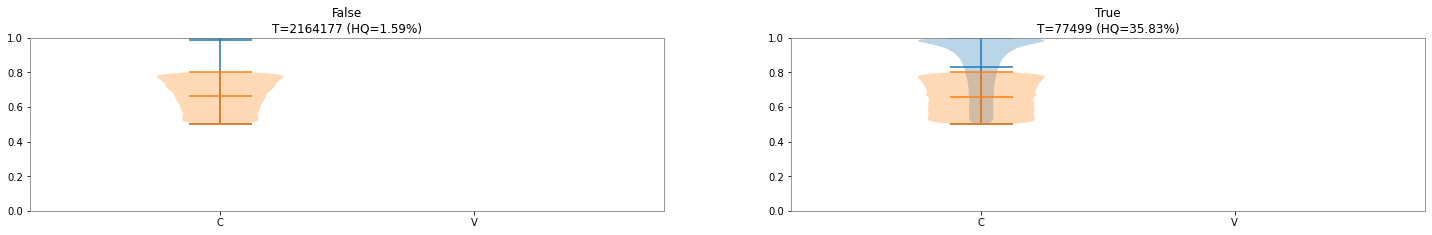

In [27]:
fig = plt.figure(figsize=(25 , 7))
gs = fig.add_gridspec(nrows=2)

box_plot_prediction_confidence(df_summary, df_low_quality_threshold, gs[0])



In [28]:
df_summary.shape

(2241710, 5)

In [29]:
df_summary[["confidence","prediction"]].groupby("prediction").describe().T

prediction               False          True
confidence count  2.164205e+06  77505.000000
           mean   9.896867e-01      0.833865
           std    4.610217e-02      0.150617
           min    5.000041e-01      0.500021
           25%    9.979274e-01      0.718105
           50%    9.986860e-01      0.883428
           75%    9.990475e-01      0.967492
           max    9.996448e-01      0.999001

In [30]:
%%time

def prepare_predictions_summary(df_full, df_high_quality_threshold):
    
    
    df_full = df_full[~df_full.RecordInTrainingData].copy()
    
    df_high_quality_threshold = df_high_quality_threshold[~df_high_quality_threshold.RecordInTrainingData].copy()


        
    
    summary_df = pd.DataFrame(df_full
                  .groupby([ "prediction"]).size()).rename(columns={0: "all_count"})

    

    thresh_df = pd.DataFrame(df_high_quality_threshold\
              .groupby('prediction').size())\
              .rename(columns={0: "thresh_count"})
    
    
    
    
    dfs = [summary_df,  thresh_df]
    result_df = pd.DataFrame()
    
    for df in dfs:
        result_df = result_df.merge(df, left_index=True,  right_index=True, how="outer")
        
        
    for col in result_df.columns:
        result_df.loc["Total",col] = result_df[col].sum()
        
    result_df = result_df.fillna(0)
        
    result_df = result_df.astype(int)
    return result_df


latex_df_results = prepare_predictions_summary(df_summary, df_high_quality_threshold)

print(latex_df_results.to_latex( index=True))

latex_df_results

\begin{tabular}{lrr}
\toprule
{} &  all\_count &  thresh\_count \\
prediction &            &               \\
\midrule
False      &    2164177 &         97078 \\
True       &      77499 &          8878 \\
Total      &    2241676 &        105956 \\
\bottomrule
\end{tabular}

CPU times: user 272 ms, sys: 5.22 ms, total: 278 ms
Wall time: 280 ms


,all_count,thresh_count
prediction,,
False,2164177,97078
True,77499,8878
Total,2241676,105956


In [31]:
df_high_quality_threshold.groupby(["prediction"]).size()

prediction
False    97080
True      8879
dtype: int64

In [32]:

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

plt.rcParams.update({'font.size': 12})

In [33]:

local_file_high_q_sample = os.path.join(local_temp, "highquality_sample.json")
local_file_low_q_sample = os.path.join(local_temp, "lowquality_sample.json")

df_high_quality_threshold.to_json(local_file_high_q_sample,  orient='records')
df_low_quality_threshold.to_json(local_file_low_q_sample,   orient='records')




In [34]:
upload_file( local_file_high_q_sample, "{}/".format( s3_output_prefix.rstrip("/")))
upload_file( local_file_low_q_sample, "{}/".format( s3_output_prefix.rstrip("/")))



In [35]:
from utils.ppi_multiclass_comparer import PpiMulticlassComparer
from utils.similarity_comparer import SimilarityComparer
import pandas as pd
import tempfile
import transformers

def get_sim_scores(ref_file_or_df, target_file_or_df, n_gram, additional_target_cols):
    marker_ref_file = ref_file_or_df
    marker_target_file = target_file_or_df

    
    if isinstance(ref_file_or_df, str):
        df_ref_marker = pd.read_json(marker_ref_file)
        df_target_marker =  pd.read_json(marker_target_file)
    else:
        df_ref_marker = marker_ref_file
        df_target_marker = marker_target_file
        
    t = transformers.AutoTokenizer.from_pretrained("bert-base-cased")
    
    comparer =  SimilarityComparer(n_gram=n_gram, max_features=None, stop_words=None, analyzer=lambda x: t.convert_ids_to_tokens(t([x], add_special_tokens=False)["input_ids"][0])[:512])
    comparison_result = comparer(df_ref_marker["abstract"].tolist(), df_target_marker["abstract"].tolist())
    
    sim_score = comparison_result[0]
    
    df_target_marker["sim_score"]  = comparison_result[0]
    return df_target_marker
    
def plot_sim_scores(df, ax, interaction, title_prefix ):
    
    for i, interaction_type in enumerate(interaction): 
        df_interaction = df.query(f"interaction_type == '{interaction_type}'")
        
        if len(df_interaction) ==0: continue
            
        ax[i].set_ylim(0,1)
        
        ax[i].set_title(f"{title_prefix} {interaction_type}")

        ax[i].tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)

        ax[i].spines['bottom'].set_color('grey')
        ax[i].spines['top'].set_color('grey') 
        ax[i].spines['right'].set_color('grey')
        ax[i].spines['left'].set_color('grey')
        
        

        ax[i].violinplot(df_interaction["best_score"],  showmeans=True )

In [36]:
df_high_quality_threshold.shape

(105959, 9)

In [37]:
df_sim_score_high = get_sim_scores(data_training_full_df, df_high_quality_threshold, n_gram=1, additional_target_cols=list(df_high_quality_threshold.columns))

df_sim_score_high.head()


Token indices sequence length is longer than the specified maximum sequence length for this model (613 > 512). Running this sequence through the model will result in indexing errors


,abstract_id,abstract,false,true,prediction,confidence,confidence_std,raw_confidence,RecordInTrainingData,sim_score
12,20791877,Subtyping of hepatitis B antigen (HBA) in bloo...,0.999453,0.000547,False,0.999453,NaN,[0.9994531273841851],False,0.520780
6,20791871,Immunological studies were performed on 24 chi...,0.998832,0.001168,False,0.998832,NaN,[0.9988319277763361],False,0.531290
13,20791880,"When a patient presents with wheezing, pulmona...",0.998835,0.001165,False,0.998835,NaN,[0.9988347887992851],False,0.351778
7,20791872,Benzoctamine (Tacitin) was given by mouth as n...,0.999041,0.000959,False,0.999041,NaN,[0.9990406632423401],False,0.567036
10,20791875,A comparative trial of co-trimoxazole and chlo...,0.999160,0.000840,False,0.999160,NaN,[0.9991598129272461],False,0.530490


<AxesSubplot:>

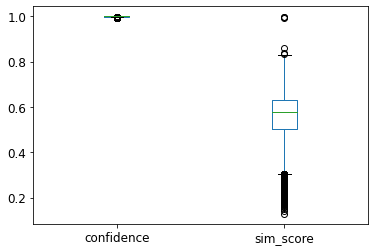

In [38]:
df_sim_score_high[["confidence","sim_score"]].plot.box()

Token indices sequence length is longer than the specified maximum sequence length for this model (613 > 512). Running this sequence through the model will result in indexing errors


<AxesSubplot:>

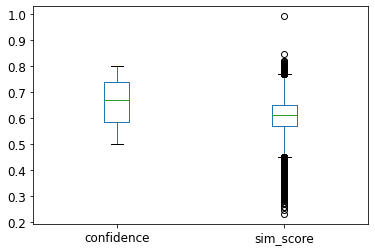

In [39]:
df_sim_score_low = get_sim_scores(data_training_full_df, df_low_quality_threshold, n_gram=1, additional_target_cols=list(df_low_quality_threshold.columns))
df_sim_score_low[["confidence","sim_score"]].plot.box()

In [40]:
def plot_box_sim_scores_confidence(df_high, df_low):
    p_unique = sorted(list(df_high["prediction"].unique()))
    
    _, axes = plt.subplots(1, len(p_unique), figsize=(30 ,8))
    
    for i, l in enumerate(p_unique):
        dh = df_high.query(f"prediction == '{l}'")
        dl = df_low.query(f"prediction == '{l}'")
        
        dl = dl[["confidence", "sim_score"]]
        dh = dh[["confidence", "sim_score"]]                   
                    
        
        data = dh.values.T.tolist()
        data.extend(dl.values.T.tolist())
      
        ax=axes[i]
        ax.boxplot(data, showmeans=True)
        ax.set_title(l)
        ax.set_xticklabels(["GHC","GHS", "GLC", "GLS"])


In [41]:
df_sim_score_high["abstract"].apply(lambda x: len(x.split(" "))).describe()

count    105959.000000
mean        132.907342
std          83.654826
min           1.000000
25%          57.000000
50%         130.000000
75%         196.000000
max        1568.000000
Name: abstract, dtype: float64

In [42]:
df_sim_score_low["abstract"].apply(lambda x: len(x.split(" "))).describe()

count    62157.000000
mean       191.162009
std         60.963785
min          8.000000
25%        154.000000
50%        195.000000
75%        230.000000
max       1099.000000
Name: abstract, dtype: float64

In [43]:
data_training_full_df["abstract"].apply(lambda x: len(x.split(" "))).describe()

count    767.000000
mean     233.923077
std       69.000061
min       46.000000
25%      189.500000
50%      236.000000
75%      266.000000
max      730.000000
Name: abstract, dtype: float64

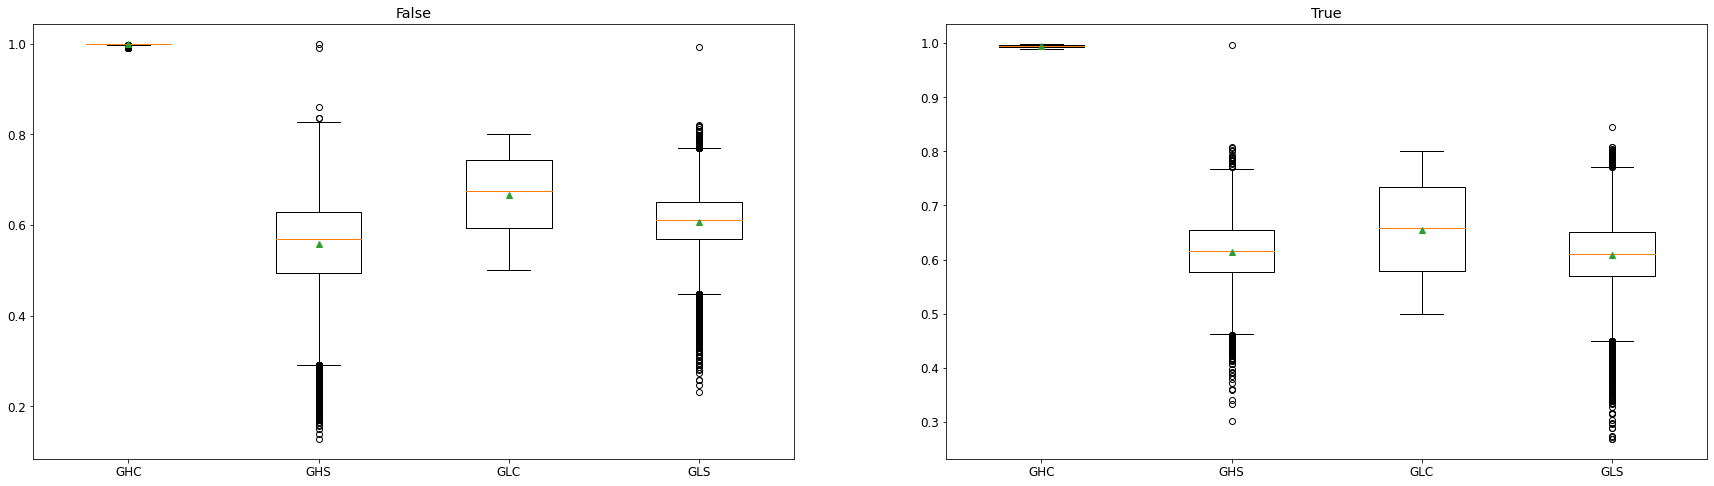

In [44]:
plot_box_sim_scores_confidence(df_sim_score_high, df_sim_score_low)

In [45]:
df_sim_score_high[["confidence", "sim_score","prediction"]].groupby(["prediction"]).describe()

confidence                                                   \
                count      mean       std       min       25%      50%   
prediction                                                               
False         97080.0  0.998372  0.001291  0.990002  0.998216  0.99876   
True           8879.0  0.994922  0.002411  0.990002  0.992999  0.99526   

                               sim_score                                \
                 75%       max     count      mean       std       min   
prediction                                                               
False       0.999074  0.999606   97080.0  0.557112  0.098787  0.128271   
True        0.997000  0.999001    8879.0  0.613430  0.058307  0.300733   

                                                    
                 25%       50%       75%       max  
prediction                                          
False       0.494376  0.569545  0.629360  0.998213  
True        0.576839  0.616211  0.654129  0.997270

In [46]:
df_sim_score_low[["confidence", "sim_score","prediction"]].groupby(["prediction"]).describe()

confidence                                                    \
                count      mean       std       min       25%       50%   
prediction                                                                
False         34386.0  0.666502  0.087467  0.500004  0.592881  0.675752   
True          27771.0  0.655295  0.088166  0.500021  0.578691  0.657920   

                               sim_score                                \
                 75%       max     count      mean       std       min   
prediction                                                               
False       0.743809  0.799998   34386.0  0.607468  0.063435  0.231792   
True        0.733576  0.800000   27771.0  0.608441  0.062417  0.268090   

                                                    
                 25%       50%       75%       max  
prediction                                          
False       0.569182  0.610625  0.649648  0.991203  
True        0.569875  0.610882  0.650358  0.845680

In [47]:
df_sim_score_high.query("sim_score < 0.65 and prediction == 'True'").sample(n=1).iloc[0]["abstract"]

'A new constitutive model for the biomechanical behaviour of smooth muscle tissue is proposed. The active muscle contraction is accomplished by the relative sliding between actin and myosin filaments, comprising contractile units in the smooth muscle cells. The model includes a chemical part, governing the cross-bridge (myosin head) cycling, that is responsible for the filament sliding. The number of activated cross-bridges govern the contractile force generated and also the contraction speed. A strain-energy function is used to describe the mechanical behaviour of the smooth muscle tissue. Besides the active contractile apparatus, the mechanical model also incorporates a passive viscoelastic part. The constitutive model was calibrated with respect to experiments on smooth muscle tissue from swine carotid artery and guinea pig taenia coli, in terms of isometric and isotonic tensile test results. The model was fully able to reproduce the experimental results.'

In [48]:
df_sim_score_low.query("sim_score < 0.65 and prediction == 'True'").sample(n=1).iloc[0]["abstract"]

'We consider the STU model as a gravity dual of a strongly coupled plasma with multiple anomalous U(1) currents. In the bulk we add additional background gauge fields to include the effects of external electric and magnetic fields on the plasma. Reducing the number of chemical potentials in the STU model to two and interpreting them as quark and chiral chemical potential, we obtain a holographic description of the chiral magnetic and chiral vortical effects (CME and CVE) in relativistic heavy-ion collisions. These effects formally appear as first-order transport coefficients in the electromagnetic current. We compute these coefficients from our model using fluid-gravity duality. We also find analogous effects in the axial-vector current. Finally, we briefly discuss a variant of our model, in which the CME/CVE is realized in the late-time dynamics of an expanding plasma.'